# Don't overfit! II

选题为"Don’t overfit!Ⅱ"，是个特别容易过拟合的问题。它是个二分类问题，但给出的训练数据只有250个，需要用这些样本训练模型，去预测19750个测试数据，此外可用的特征有300个之多。

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.decomposition import PCA
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
#读取数据集
train_data = pd.read_csv(r'./train.csv')
test_data = pd.read_csv(r'./test.csv')
train_data.shape

(250, 302)

In [3]:
test_data.shape

(19750, 301)

In [4]:
train_data.head(5)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0.0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0.0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1.0,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0.0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643


In [5]:
test_data.head(5)

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,...,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,...,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,...,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,...,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,...,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010


In [6]:
# 检查数据集是否存在空值
train_is_null = train_data.isnull().any().any()
test_is_null = test_data.isnull().any().any()

# 输出结果
print(train_is_null)
print(test_is_null)

False
False


#  1.数据预处理

## （1）数据标准化 

In [7]:
#提取训练集中除'id'和'target'两列外的数值
target_col=['target']
id_dataset=['id']
num_cols=[x for x in train_data.columns if x not in target_col + id_dataset]

#数据标准化
std=StandardScaler()
scaled=std.fit_transform(train_data[num_cols])
#将标准化后的数据转化为dataframe
scaled=pd.DataFrame(scaled,columns=num_cols)

train_copy=train_data.copy()
train_copy=train_copy.drop(columns=num_cols,axis=1)
train_copy=train_copy.merge(scaled,left_index=True,right_index=True,how="left")

#删除id列,将整理后的数据储存再train_copy中
train_copy=train_copy.drop(columns=['id'],axis=1)
print(train_copy)

     target         0         1         2         3         4         5  \
0       1.0 -0.974717 -1.169956 -0.731456  0.535098  1.142759  0.540623   
1       0.0 -0.737309  0.283037  1.682304  1.308350  1.821951 -0.074454   
2       0.0  0.198240  1.456971 -0.851523 -1.012478 -0.006887  0.032999   
3       1.0 -0.896252 -0.962236 -1.483945  0.287014  0.563168  0.697171   
4       0.0  0.914488 -1.584348  0.446442 -0.255336 -0.245293 -0.780311   
..      ...       ...       ...       ...       ...       ...       ...   
245     1.0  0.030243 -0.194300 -1.287284  0.786405  0.426482  1.550313   
246     0.0 -0.136747 -1.441671 -2.215733 -0.306886 -0.282379  0.834267   
247     0.0 -2.242234 -1.925303 -0.882575  0.840103 -0.921306 -2.452320   
248     1.0 -0.355042 -0.215282 -0.882575  0.411593  0.011126 -1.269408   
249     0.0  0.827975  1.114967  1.285876 -2.943458  0.202910  1.866188   

            6         7         8  ...       290       291       292  \
0   -0.423820  0.349920 -0.

train_copy为原始训练集数据去掉'id'列且标准化后的数据，我们对测试集也进行相同操作。

In [8]:
#对测试集数据进行标准化处理
num_cols=[x for x in test_data.columns if x not in target_col + id_dataset]

std=StandardScaler()
scaled=std.fit_transform(test_data[num_cols])
scaled=pd.DataFrame(scaled,columns=num_cols)

test_copy=test_data.copy()
test_copy=test_copy.drop(columns=num_cols,axis=1)
test_copy=test_copy.merge(scaled,left_index=True,right_index=True,how="left")
test_copy=test_copy.drop(columns=['id'],axis=1)
print(test_copy)

              0         1         2         3         4         5         6  \
0     -0.689978  1.722787 -0.746937 -0.843492  0.160822 -1.136479  0.232587   
1     -0.744138 -0.245007  0.055732  0.054980  1.163594  2.454844  0.824811   
2      1.111361  1.039248  1.214809  1.529602  0.277143 -0.089010  0.235578   
3     -0.946739  0.217006 -0.056083  0.574724 -1.532860 -1.106551  0.451929   
4     -0.219583 -0.549356  2.633456  0.859777 -0.373656  0.310026  0.503774   
...         ...       ...       ...       ...       ...       ...       ...   
19745  0.620907 -0.238022 -1.176225  0.955467  1.268885 -1.295096 -1.321754   
19746 -0.976828  0.577236 -0.484372 -0.522178 -0.422792 -2.681745  0.018229   
19747 -1.579614  0.015437 -1.098354  0.437737 -0.260343 -1.773939  0.174760   
19748  0.185617 -3.151794  0.898334  0.643217  0.628113  0.293067  0.569577   
19749  0.467453  3.050949  1.439436 -0.744781 -2.297975  0.434725 -0.405501   

              7         8         9  ...       290 

In [9]:
# 划分训练集和测试集
train, test = train_test_split(train_copy, test_size=0.3, random_state=70, shuffle=True)

In [10]:
#随机过采样
# 分离多数类和少数类
train_majority = train[train.target == 0]
train_minority = train[train.target == 1]

# 随机过采样少数类
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # 允许放回抽样
                                 n_samples=len(train_majority),    # 过采样至与多数类样本相同数量
                                 random_state=42)  # 固定随机种子

# 合并过采样后的数据集
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# 查看过采样后的类别分布
print("过采样后的类别分布:")
print(train_upsampled['target'].value_counts())

过采样后的类别分布:
target
0.0    127
1.0    127
Name: count, dtype: int64


## （2）数据描述性统计

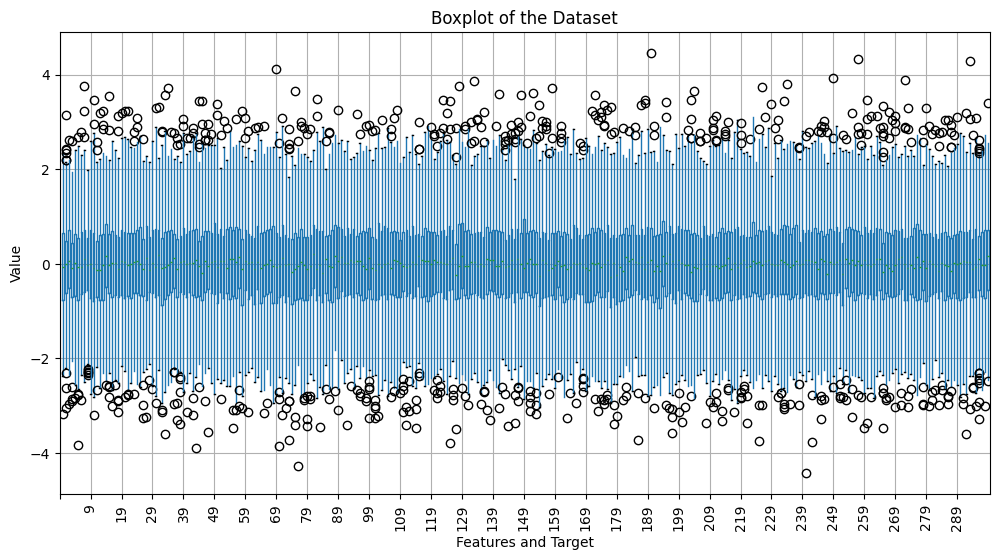

In [11]:
# 提取原始训练集特征列
features = train_data[num_cols]
#print(features)

# 绘制箱型图
plt.figure(figsize=(12, 6))
features.boxplot()
plt.title('Boxplot of the Dataset')
plt.xlabel('Features and Target')
plt.ylabel('Value')
x_ticks = np.arange(0,300, 10)  # 横轴刻度范围为0到299，间隔为10
plt.xticks(x_ticks,rotation=90)
plt.show()

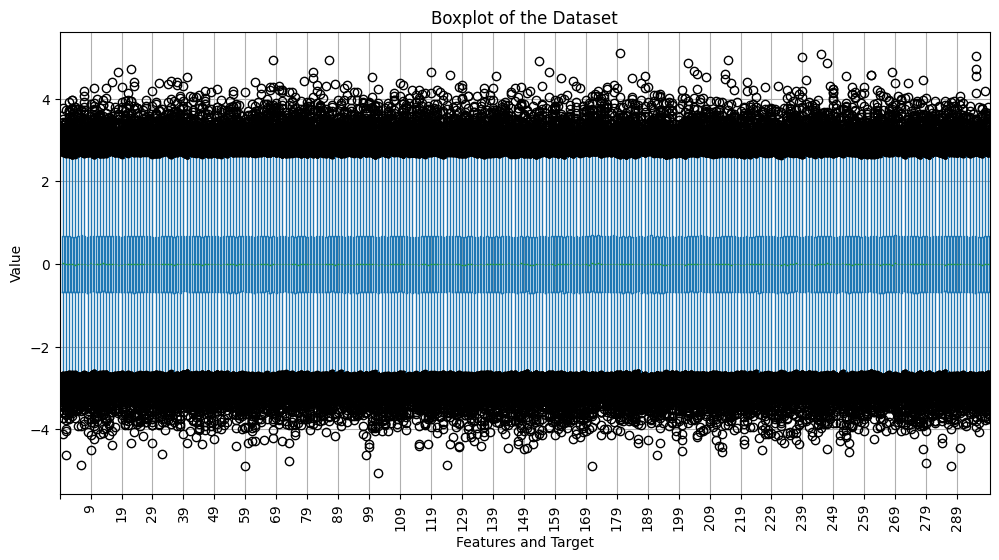

In [12]:
# 提取原始训练集特征列
features_test = test_data[num_cols]
#print(features)

# 绘制箱型图
plt.figure(figsize=(12, 6))
features_test.boxplot()
plt.title('Boxplot of the Dataset')
plt.xlabel('Features and Target')
plt.ylabel('Value')
x_ticks = np.arange(0,300, 10)  # 横轴刻度范围为0到299，间隔为10
plt.xticks(x_ticks,rotation=90)
plt.show()

根据上述箱型图可以看出原始训练集和测试集大致以0为均值，方差绝对值不超过2.5。据此可推测数据集可能接近于正态分布。

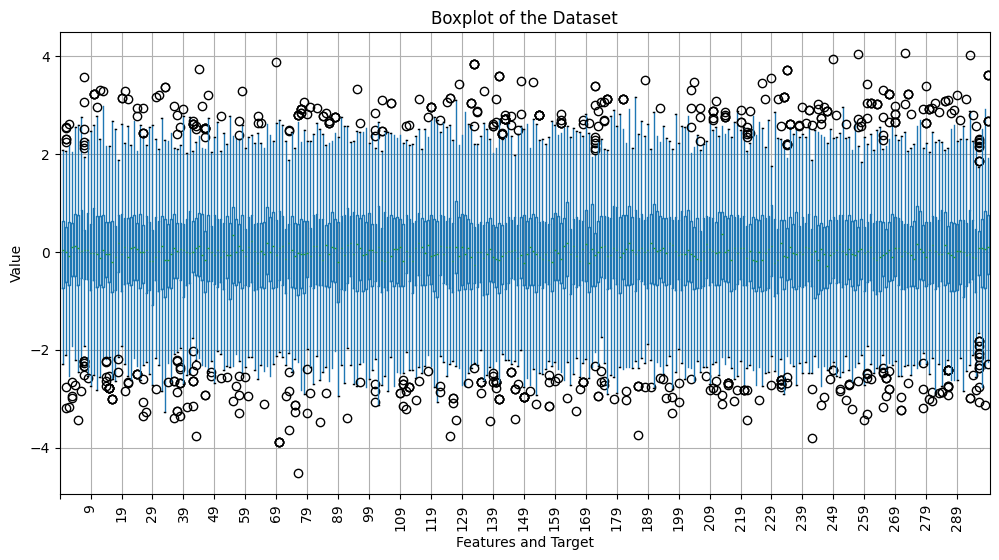

In [13]:
# 提取过采样后的数据集特征列
features = train_upsampled[num_cols]
#print(features)

# 绘制箱型图
plt.figure(figsize=(12, 6))
features.boxplot()
plt.title('Boxplot of the Dataset')
plt.xlabel('Features and Target')
plt.ylabel('Value')
x_ticks = np.arange(0,300, 10)  # 横轴刻度范围为0到299，间隔为10
plt.xticks(x_ticks,rotation=90)
plt.show()

根据上述箱型图可以看出过采样后的数据集也是大致以0为均值，方差绝对值不超过2.5。据此可推测数据集可能接近于正态分布。

# 2. 特征筛选

由于该数据集中特征较多，对训练集进行特征筛选。

In [14]:
#print(train_upsampled)

0     -0.112066
1     -0.180263
2     -0.062074
3      0.215703
4      0.202224
         ...   
295   -0.145896
296   -0.087742
297   -0.064115
298   -0.004511
299    0.064061
Length: 300, dtype: float64


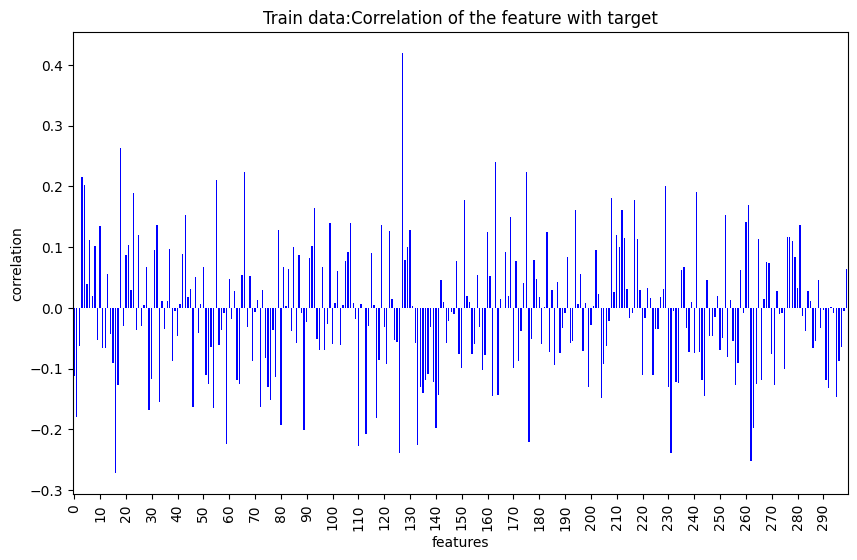

In [15]:
# 提取特征列和目标列，train_copy已经去掉'id'列
train_features = train_upsampled.drop('target', axis=1)
train_target = train_upsampled['target']

# 计算特征与目标列的相关性
train_correlation = train_features.corrwith(train_target,method='spearman')

# 打印相关性结果
print(train_correlation)

# 绘制相关性图
plt.figure(figsize=(10, 6))
train_correlation.plot(kind='bar', color='blue')
plt.xlabel('features')
plt.ylabel('correlation')
plt.title('Train data:Correlation of the feature with target')
x_ticks = np.arange(0, 300, 10)  # 横轴刻度范围为0到299，间隔为10
plt.xticks(x_ticks)
plt.show()

通过各个特征与target的相关性分析可以发现存在许多特征与target相关性较弱，为方便进一步分析，我们剔除相关性小于0.01的特征，共删除了181个特征，然后将剩余的特征用重要性排序方法对特征进行再次筛选。

In [16]:
# 去除相关性低于0.01的特征
low_corr_features = train_correlation[abs(train_correlation) < 0.01]
filtered_features = train_features.drop(low_corr_features.index, axis=1)

# 计算去除的特征数量
removed_feature_count = len(low_corr_features)
print("去除的特征数量：", removed_feature_count)
#print(filtered_features )

去除的特征数量： 32


## 1.随机森林分类器降维 

In [17]:
target = train_target
# 创建随机森林分类器模型
model = RandomForestClassifier(random_state=42)

# 拟合随机森林模型
model.fit(filtered_features, target)

# 获取特征重要性得分
feature_importances = model.feature_importances_

# 创建特征重要性得分的索引数组
feature_indices = np.argsort(feature_importances)[::-1]

# 根据特征重要性得分对剩余特征进行排序
sorted_features = filtered_features.columns[feature_indices]

# 打印特征重要性排序结果
print("特征重要性排序：", sorted_features)

特征重要性排序： Index(['127', '66', '18', '16', '3', '243', '139', '80', '271', '126',
       ...
       '174', '34', '284', '281', '280', '44', '242', '153', '257', '65'],
      dtype='object', length=268)


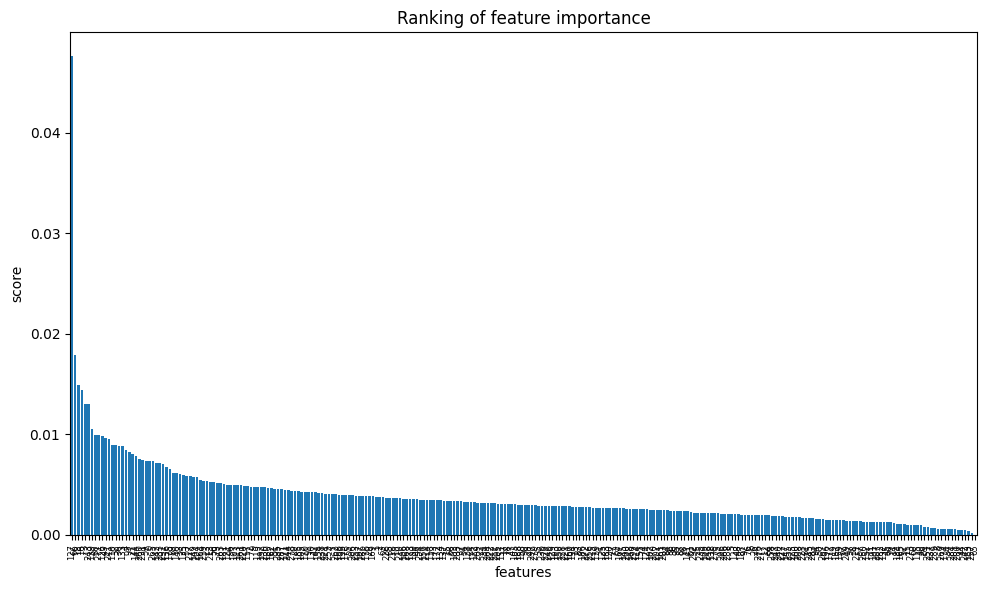

In [18]:
# 创建特征重要性得分的索引数组和排序后的特征重要性得分
feature_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[feature_indices]

# 创建特征名称列表
sorted_feature_names = filtered_features.columns[feature_indices]

# 绘制条形图
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_names)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90, fontsize=6) 
plt.xlabel('features')
plt.ylabel('score')
plt.title('Ranking of feature importance')
plt.xlim(-0.5, len(sorted_feature_names) - 0.5)  # 根据特征数量调整横轴范围
plt.tight_layout()
plt.show()

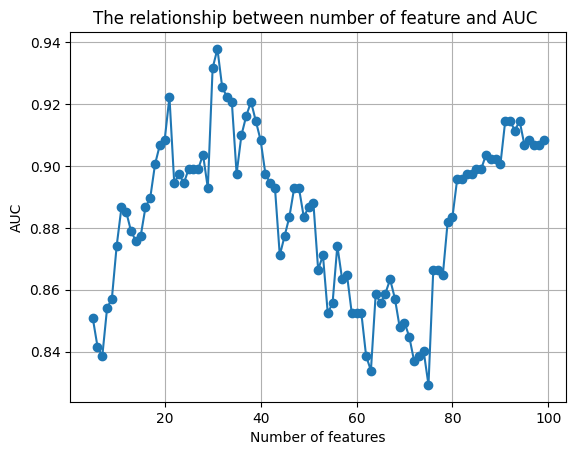

In [19]:
# 定义空列表存储特征数量和对应的 AUC
feature_counts = []
auc_scores = []

# 根据随机森林的特征重要性排序结果，选择不同数量的特征
for k in range(5, 100, 1):
    selected_features = sorted_feature_names[:k]  # 选择前 k 个特征
    X_selected = filtered_features[selected_features]

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_selected, target, test_size=0.2, random_state=42)

    # 训练 logistic 回归模型
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # 预测测试集
    y_pred = model.predict_proba(X_test)[:, 1]

    # 计算 AUC
    auc = roc_auc_score(y_test, y_pred)

    # 存储特征数量和对应的 AUC
    feature_counts.append(k)
    auc_scores.append(auc)

# 绘制折线图
plt.plot(feature_counts, auc_scores, marker='o')
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.title('The relationship between number of feature and AUC ')
plt.grid(True)
plt.show()

In [20]:
# 获取最大 AUC 对应的特征数量的索引
max_auc_index = np.argmax(auc_scores)

# 输出最大 AUC 对应的特征数量
max_auc_features = feature_counts[max_auc_index]
print(f"最大 AUC 对应的特征数量: {max_auc_features}")

最大 AUC 对应的特征数量: 31


In [21]:
# 获取选择特征的数据
selected_data = filtered_features[selected_features]

# 输出选择的特征及相应的数据
selected_data_max_auc_features = selected_data.iloc[:, :max_auc_features]
print(f"前{max_auc_features}个特征及相应的数据:")
print(selected_data_max_auc_features)

前31个特征及相应的数据:
          127        66        18        16         3       243       139  \
221 -0.396861  0.064562 -0.122601  0.939800 -0.256410 -0.755281  1.289345   
189  1.953612 -1.653669  0.117933  0.834039 -0.458315 -0.520158 -0.733752   
239  0.671722 -0.679197 -0.263674  0.727260  0.036781  0.886677  0.658047   
46  -0.489157 -1.132195 -0.551909 -1.701185  1.035564  1.218386 -1.061481   
124  0.082053  0.923150 -0.563073 -0.149339  0.583427 -1.314308  0.460569   
..        ...       ...       ...       ...       ...       ...       ...   
115 -0.037932  1.348757 -0.414896 -0.670011 -0.606521 -1.873335 -0.621358   
230 -0.368146 -0.326281 -1.115186  0.018455 -0.065245 -0.486987  0.063512   
196  1.169095  0.555485  0.625389  0.273706  1.784114 -0.198206  0.733676   
90   1.373172 -0.338922  1.308425  1.082171 -0.089946  1.034970 -0.740054   
169 -0.483004 -0.763476  0.646702 -1.434747  0.285940 -0.002107 -0.337746   

           80       271       126  ...       231        59   

## 2.PCA降维 

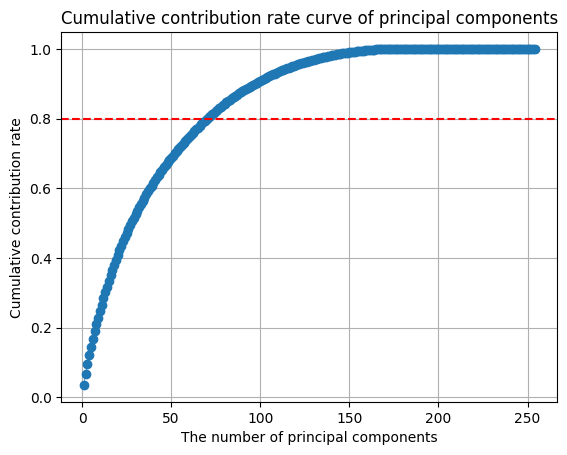

最优主成分数量是71
(254, 71)


In [22]:
# 创建PCA对象
pca = PCA(random_state=50)

# 对数据进行PCA降维
reduced_data = pca.fit_transform(filtered_features)

# 获取主成分的累计贡献率
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 绘制主成分的累计贡献率曲线
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o',linewidth=0.5)
plt.xlabel('The number of principal components')
plt.ylabel('Cumulative contribution rate')
plt.title('Cumulative contribution rate curve of principal components')
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--')  # 绘制累计贡献率为0.8的水平线，颜色为红色，线型为虚线
plt.show()

# 选择最优主成分数量
optimal_n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
print(f"最优主成分数量是{optimal_n_components}")

#components_set = int(input("请输入主成分数量："))  # 设置聚类类别的数量
components_set = int(optimal_n_components)
# 重新创建PCA对象，指定最优主成分数量
pca_optimal = PCA(n_components=components_set)  #

# 对数据进行降维
reduced_data_PCA = pca_optimal.fit_transform(filtered_features)

# 输出降维后的数据
print(reduced_data_PCA.shape)

下面我们选择用随机森林分类器得到的降维结果进行进一步建立分类模型。

# 一、使用随机森林所选特征建立分类模型

## [Logistic回归](https://blog.csdn.net/hgnuxc_1993/article/details/114680399)

In [23]:
#特征的列名
index = selected_data.columns.tolist()[0:max_auc_features]
X = train_upsampled[index]
y = train_upsampled['target']

**超参数类型**：  
正则化类型elasticnet: [弹性网络回归](https://blog.csdn.net/sai_simon/article/details/122376407)  
Saga：指定优化器类型，线性收敛的随机优化算法。【线性收敛的随机优化算法的的变种。】  
l1_ratio：弹性网络参数，其中0 <= l1_ratio <=1

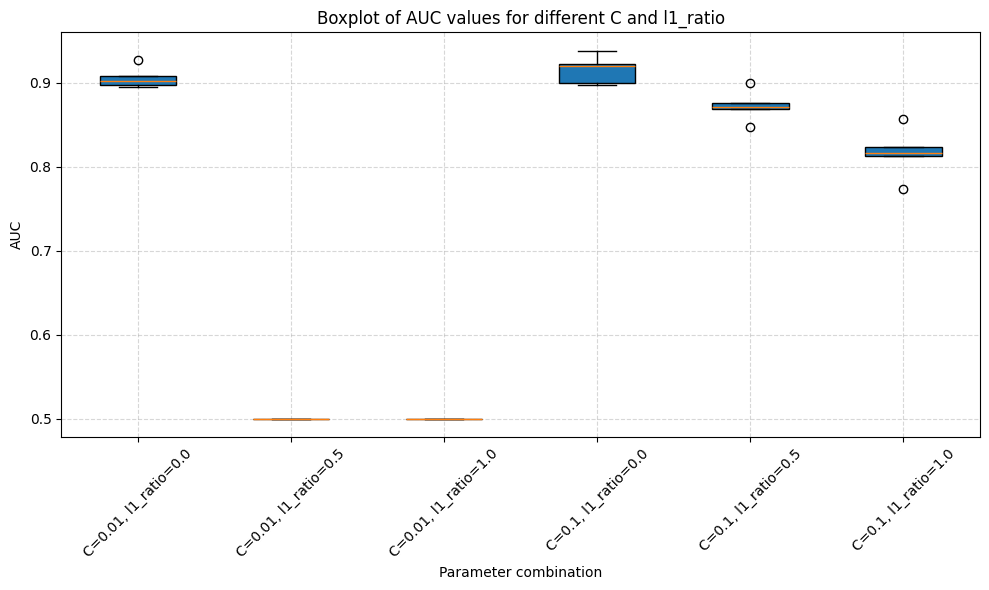

Best param`eters found: {'C': 0.1, 'l1_ratio': 0.0, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation score: 0.9150281943395548


In [24]:
# 定义参数网格
param_grid = {
    'C': [0.01, 0.1],       # 正则化强度
    'penalty': ['elasticnet'], # 正则化类型
    'solver': ['saga'],  # solver 必须与正则化类型兼容，'saga' 支持所有正则化
    'l1_ratio': np.linspace(0, 1, 3)     # l1_ratio 仅在 penalty 为 'elasticnet' 时使用
}

# 初始化逻辑回归分类器
logreg_classifier = LogisticRegression(random_state=42, max_iter=10000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=logreg_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的AUC值
auc_values = []
for c in param_grid['C']:
    for l1_ratio in param_grid['l1_ratio']:
        auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == c and grid_search.cv_results_['params'][j]['l1_ratio'] == l1_ratio])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(ticks=np.arange(1, len(param_grid['C']) * len(param_grid['l1_ratio']) + 1), labels=[f"C={c}, l1_ratio={l1_ratio}" for c in param_grid['C'] for l1_ratio in param_grid['l1_ratio']], rotation=45)
plt.title('Boxplot of AUC values for different C and l1_ratio')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best param`eters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_logreg_classifier = grid_search.best_estimator_

## [随机森林](https://blog.csdn.net/sai_simon/article/details/123082619)

**随机森林超参数**  

n_estimators：森林中决策树的数量。默认100
表示这是森林中树木的数量，即基基评估器的数量。这个参数对随机森林模型的精确性影响是单调的，n_estimators越大，模型的效果往往越好。但是相应的，任何模型都有决策边界，n_estimators达到一定的程度之后，随机森林的精确性往往不在上升或开始波动，并且，n_estimators越大，需要的计算量和内存也越大，训练的时间也会越来越长。对于这个参数，我们是渴望在训练难度和模型效果之间取得平衡。

max_depth：树的最大深度。如果为None，则将节点展开，直到所有叶子都是纯净的(只有一个类)，或者直到所有叶子都包含少于min_samples_split个样本。默认是None。

min_samples_split：拆分内部节点所需的最少样本数：如果为int，则将min_samples_split视为最小值。如果为float，则min_samples_split是一个分数，而ceil（min_samples_split * n_samples）是每个拆分的最小样本数。默认是2。

min_samples_leaf：在叶节点处需要的最小样本数。仅在任何深度的分割点在左分支和右分支中的每个分支上至少留下min_samples_leaf个训练样本时，才考虑。这可能具有平滑模型的效果，尤其是在回归中。如果为int，则将min_samples_leaf视为最小值。如果为float，则min_samples_leaf是分数，而ceil（min_samples_leaf * n_samples）是每个节点的最小样本数。默认是1。

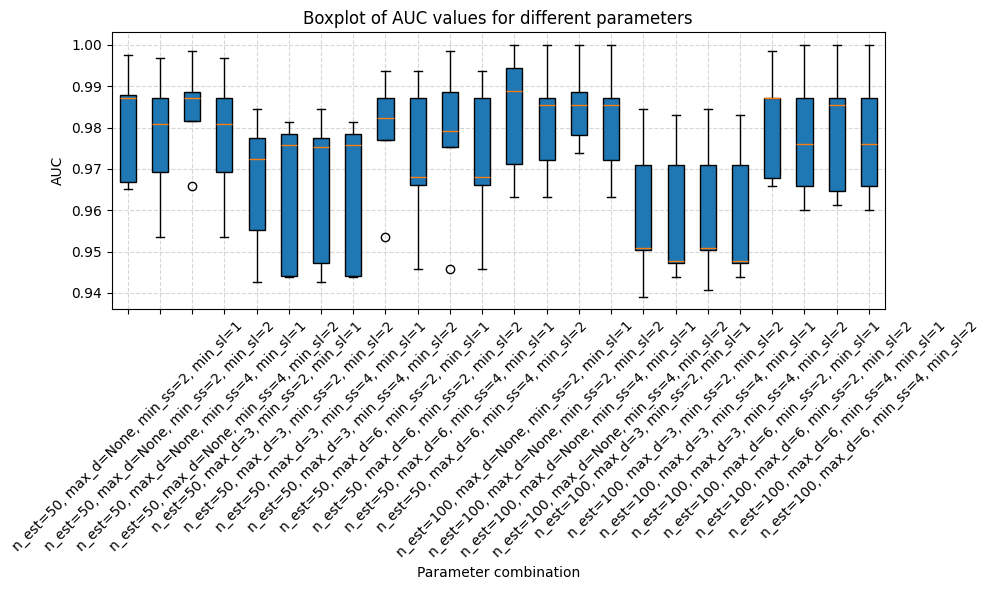

Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
Best cross-validation score: 0.9852787247815298


In [25]:
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100],      # 决策树的数量
    'max_depth': [None, 3, 6],       # 树的最大深度
    'min_samples_split': [2, 4],     # 内部节点再划分所需的最小样本数
    'min_samples_leaf': [1, 2]       # 叶子节点所需的最小样本数
}

# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(random_state=42)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的AUC值
auc_values = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['n_estimators'] == n_estimators and grid_search.cv_results_['params'][j]['max_depth'] == max_depth and grid_search.cv_results_['params'][j]['min_samples_split'] == min_samples_split and grid_search.cv_results_['params'][j]['min_samples_leaf'] == min_samples_leaf])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.xticks(ticks=np.arange(1, len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) + 1), labels=[f"n_est={n_estimators}, max_d={max_depth}, min_ss={min_samples_split}, min_sl={min_samples_leaf}" for n_estimators in param_grid['n_estimators'] for max_depth in param_grid['max_depth'] for min_samples_split in param_grid['min_samples_split'] for min_samples_leaf in param_grid['min_samples_leaf']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_rf_classifier = grid_search.best_estimator_

## SVM  

通过在特征空间中找到一个最优的超平面来进行分类，并且间隔最大。

1.C：根据官方文档，这是一个软间隔分类器，对于在边界内的点有惩罚系数C，C的取值在0-1。0之间，默认值为1.0

C越大代表这个分类器对在边界内的噪声点的容忍度越小，分类准确率高，但是容易过拟合，泛化能力差。所以一般情况下，应该适当减小C，对在边界范围内的噪声有一定容忍。

2.kernel:核函数类型，默认为‘rbf’，高斯核函数

其他可选项有：

'linear':线性核函数

'poly':多项式核函数

'sigmoid':sigmoid核函数

4.gamma:核函数系数，只对'rbf','poly','sigmoid'起作用

默认为'auto'，此时值为样本特征数的倒数，即1/n_features.

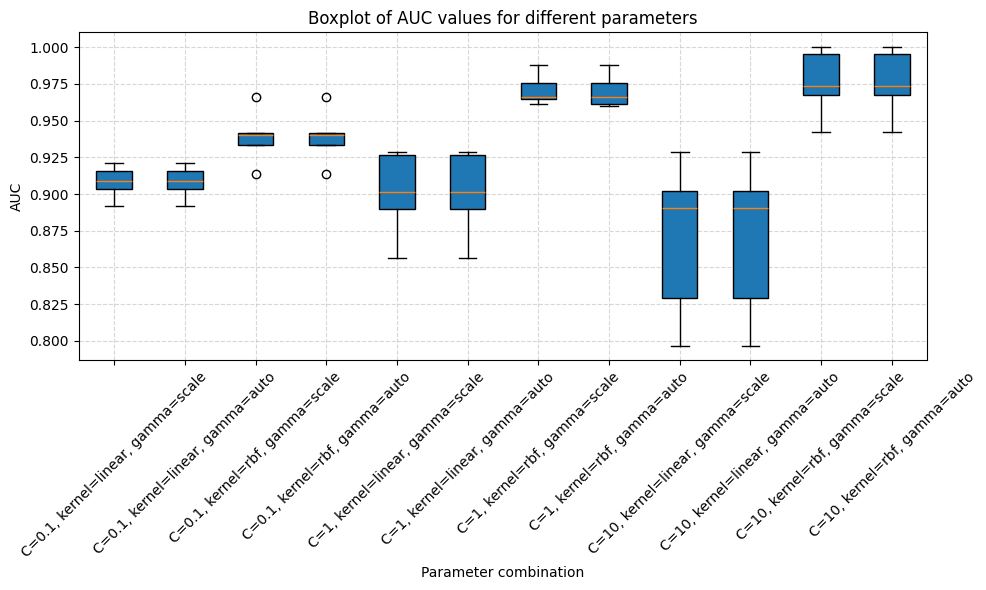

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.9758653961746528


In [26]:
# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],              # 正则化参数
    'kernel': ['linear', 'rbf'],    # 核函数类型
    'gamma': ['scale', 'auto']      # 核系数
}

# 初始化 SVM 分类器
svm_classifier = SVC(random_state=42,probability=True)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的 AUC 值
auc_values = []
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == C and grid_search.cv_results_['params'][j]['kernel'] == kernel and grid_search.cv_results_['params'][j]['gamma'] == gamma])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e']
plt.xticks(ticks=np.arange(1, len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) + 1), labels=[f"C={C}, kernel={kernel}, gamma={gamma}" for C in param_grid['C'] for kernel in param_grid['kernel'] for gamma in param_grid['gamma']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_svm_classifier = grid_search.best_estimator_

## 神经网络：sklearn和TensorFlow  

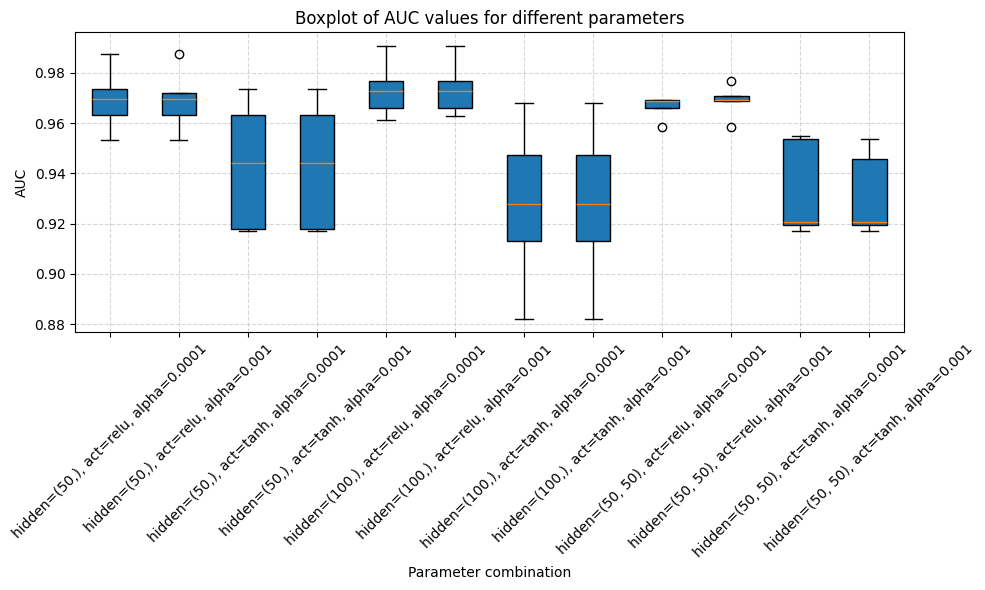

Best parameters found: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Best cross-validation score: 0.973844933701175


In [27]:
# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],   # 隐藏层神经元数量
    'activation': ['relu', 'tanh'],                    # 激活函数类型
    'solver': ['adam'],                                # 优化器类型
    'alpha': [0.0001, 0.001]                           # L2正则化参数
}

# 初始化神经网络分类器
nn_classifier = MLPClassifier(random_state=42, max_iter=1000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X, y)

# 提取每组参数对应的 AUC 值
auc_values = []
for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for alpha in param_grid['alpha']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['hidden_layer_sizes'] == hidden_layer_sizes and grid_search.cv_results_['params'][j]['activation'] == activation and grid_search.cv_results_['params'][j]['alpha'] == alpha])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e']
plt.xticks(ticks=np.arange(1, len(param_grid['hidden_layer_sizes']) * len(param_grid['activation']) * len(param_grid['alpha']) + 1), labels=[f"hidden={hidden_layer_sizes}, act={activation}, alpha={alpha}" for hidden_layer_sizes in param_grid['hidden_layer_sizes'] for activation in param_grid['activation'] for alpha in param_grid['alpha']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_nn_classifier = grid_search.best_estimator_

In [29]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)
index = selected_data.columns.tolist()[0:max_auc_features]
X = train_upsampled[index]
y = train_upsampled['target']

# 定义模型
model = Sequential()

# 添加隐藏层
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001), input_shape=(max_auc_features,)))

# 添加输出层，二分类问题
model.add(Dense(1, activation='sigmoid'))

# 编译模型
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
history = model.fit(X, y, epochs=1000, batch_size=32, validation_split=0.2,verbose=0)

## 分析训练模型在测试集上的性能

In [30]:
print(f'测试集大小：{test.shape}')
test_X = test[index]
test_y = test['target']

测试集大小：(75, 301)


In [31]:
# 预测
logistic = best_logreg_classifier.predict(test_X)
rf= best_rf_classifier.predict(test_X)
svm = best_svm_classifier.predict(test_X)
nn = best_nn_classifier.predict(test_X)

result = pd.DataFrame(test['target'])
result['logsitic_pred'] = logistic
result['rf_pred'] = rf
result['svm_pred'] = svm
result['nn_pred'] = nn
print(f'accuracy_logistic:{np.sum(logistic==test_y)/test.shape[0]}\n')
print(f'accuracy_rf:{np.sum(rf==test_y)/test.shape[0]}\n')
print(f'accuracy_svm:{np.sum(svm==test_y)/test.shape[0]}\n')
print(f'accuracy_nn:{np.sum(nn==test_y)/test.shape[0]}\n')

accuracy_logistic:0.7333333333333333

accuracy_rf:0.72

accuracy_svm:0.7733333333333333

accuracy_nn:0.8



In [32]:
# 硬投票结果
zero_counts = (result[['logsitic_pred', 'rf_pred', 'svm_pred', 'nn_pred']] == 0).sum(axis=1)
one_counts = (result[['logsitic_pred', 'rf_pred', 'svm_pred', 'nn_pred']] == 1).sum(axis=1)

# 确定每行中0和1出现次数较多的值作为目标值
result['vote'] = np.where(zero_counts > one_counts, 0, 1)
count = np.sum(result['vote']==test_y)
print(f'accuracy_硬投票:{count/test.shape[0]}\n')

accuracy_硬投票:0.7733333333333333



In [33]:
# 软投票结果
logistic_prob = best_logreg_classifier.predict_proba(test_X)
rf_prob= best_rf_classifier.predict_proba(test_X)
svm_prob = best_svm_classifier.predict_proba(test_X)
nn_prob = best_nn_classifier.predict_proba(test_X)

prob_sum = (logistic_prob+rf_prob+svm_prob+nn_prob)/4
result_prob = np.where(prob_sum[:, 0] > prob_sum[:, 1], 0, 1)

count_prob = np.sum(result_prob==test_y)
print(f'accuracy_软投票:{count_prob/test.shape[0]}\n')

accuracy_软投票:0.8133333333333334



In [34]:
# 生成混淆矩阵
conf_mat_logistic = confusion_matrix(result['target'], logistic)


# 输出混淆矩阵
print(conf_mat_logistic)

[[45 11]
 [ 9 10]]


In [35]:
# 生成混淆矩阵
conf_mat_rf = confusion_matrix(result['target'], rf)


# 输出混淆矩阵
print(conf_mat_rf)

[[50  6]
 [15  4]]


In [36]:
# 生成混淆矩阵
conf_mat_svm = confusion_matrix(result['target'], svm)


# 输出混淆矩阵
print(conf_mat_svm)

[[53  3]
 [14  5]]


In [37]:
# 生成混淆矩阵
conf_mat_nn = confusion_matrix(result['target'], nn)


# 输出混淆矩阵
print(conf_mat_nn)

[[51  5]
 [10  9]]


## 使用训练模型进行测试集预测

### [投票表决](https://blog.csdn.net/qq_45396577/article/details/115659180)

投票法（voting）是集成学习里面针对分类问题的一种结合策略。是一种遵循少数服从多数原则的集成学习模型，通过多个模型的集成降低方差，从而提高模型的 鲁棒性 （算法对数据变化的容忍度有多高）。在理想情况下，投票法的预测效果应当优于任何一个基模型的预测效果。

**由上面我们看到软投票的结果好于硬投票，我们使用软投票结果预测kaggle提供的无标签测试集数据：`test_data`，并将预测结果提交到kaggle中。**

In [38]:
#测试集数据
test_data

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,-0.677,1.721,-0.745,-0.838,0.149,-1.138,0.242,0.504,-1.829,...,-1.180,-0.403,0.759,-0.600,0.951,-0.349,0.446,-0.819,-0.277,1.297
1,251,-0.731,-0.251,0.059,0.054,1.149,2.462,0.836,0.719,-2.269,...,1.297,1.114,0.657,0.760,0.899,-1.612,-1.701,1.107,-0.314,-0.641
2,252,1.119,1.036,1.220,1.518,0.265,-0.088,0.245,-0.533,-0.921,...,-0.864,-0.736,0.367,0.154,0.830,-1.352,0.914,0.377,0.588,-0.912
3,253,-0.933,0.212,-0.053,0.570,-1.540,-1.108,0.462,1.022,-0.215,...,0.063,-0.958,0.762,-0.213,-2.171,0.830,1.435,0.125,2.782,0.619
4,254,-0.208,-0.556,2.641,0.853,-0.384,0.312,0.514,0.481,-1.929,...,-0.689,0.213,0.568,-0.935,-0.015,0.267,0.739,1.340,-0.178,1.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19745,19995,0.630,-0.244,-1.175,0.948,1.254,-1.297,-1.317,1.470,-1.958,...,-1.171,0.902,-0.006,-0.893,0.238,1.157,0.895,-1.760,-2.381,0.901
19746,19996,-0.963,0.573,-0.482,-0.519,-0.433,-2.687,0.027,0.500,1.498,...,1.366,-0.262,1.583,2.449,-1.081,-0.199,-1.342,-1.732,0.263,-0.337
19747,19997,-1.564,0.010,-1.097,0.434,-0.271,-1.777,0.184,-0.916,-0.527,...,-0.712,0.212,0.613,0.514,0.440,0.640,0.175,0.825,-0.809,1.653
19748,19998,0.196,-3.164,0.903,0.638,0.615,0.295,0.580,0.398,-0.510,...,-0.406,1.489,1.571,-0.076,-0.438,0.755,1.812,0.770,-0.870,0.160


In [39]:
X_test = test_data[index]

# 预测
logistic_pred = best_logreg_classifier.predict_proba(X_test)
rf_pred = best_rf_classifier.predict_proba(X_test)
svm_pred = best_svm_classifier.predict_proba(X_test)
nn_pred = best_nn_classifier.predict_proba(X_test)

submission = pd.read_csv(r'./sample_submission.csv')
prob_sum = logistic_pred+rf_pred+svm_pred+nn_pred
submission['target'] = np.where(prob_sum[:, 0] > prob_sum[:, 1], 0, 1)

submission

,id,target
0,250,1
1,251,0
2,252,0
3,253,0
4,254,1
...,...,...
19745,19995,0
19746,19996,1
19747,19997,0
19748,19998,0


In [40]:
submission['target'].value_counts()

target
0    16530
1     3220
Name: count, dtype: int64

In [41]:
submission

,id,target
0,250,1
1,251,0
2,252,0
3,253,0
4,254,1
...,...,...
19745,19995,0
19746,19996,1
19747,19997,0
19748,19998,0


In [42]:
submission.to_csv(r'./submission.csv', index=False)

# 二、使用主成分分析降维结果建立预测模型

In [43]:
# 对数据进行降维
# reduced_data_PCA = pca_optimal.fit_transform(filtered_features)

# 降维后的数据 reduced_data_PCA
X_PCA = reduced_data_PCA
y_PCA = train_upsampled['target']

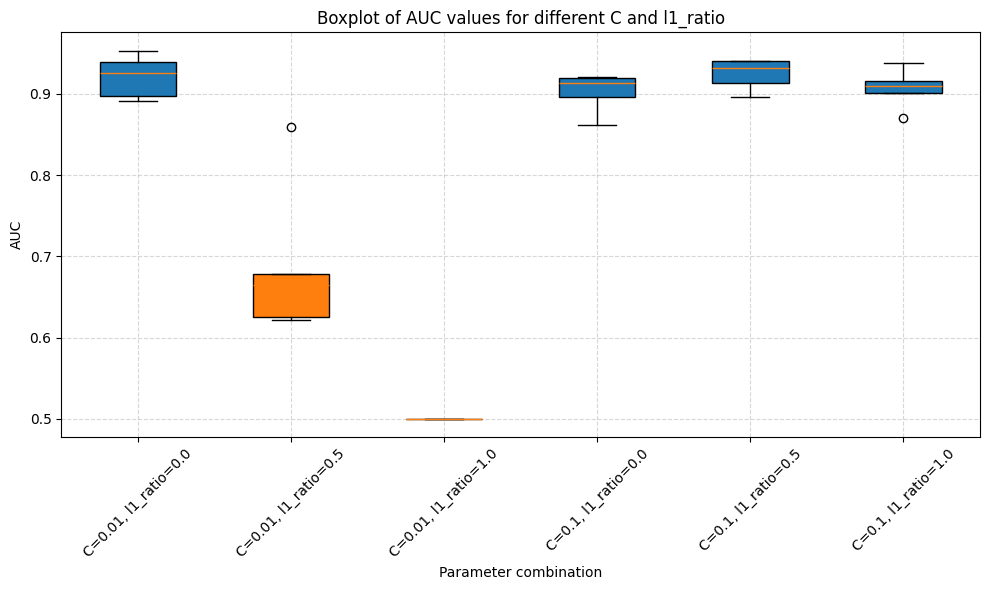

Best param`eters found: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}
Best cross-validation score: 0.9245001746733864


In [44]:
# Logistic回归
# 定义参数网格
param_grid = {
    'C': [0.01, 0.1],       # 正则化强度
    'penalty': ['elasticnet'], # 正则化类型
    'solver': ['saga'],  # solver 必须与正则化类型兼容，'saga' 支持所有正则化
    'l1_ratio': np.linspace(0, 1, 3)     # l1_ratio 仅在 penalty 为 'elasticnet' 时使用
}

# 初始化逻辑回归分类器
logreg_classifier = LogisticRegression(random_state=42, max_iter=10000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=logreg_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_PCA, y_PCA)

# 提取每组参数对应的AUC值
auc_values = []
for c in param_grid['C']:
    for l1_ratio in param_grid['l1_ratio']:
        auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == c and grid_search.cv_results_['params'][j]['l1_ratio'] == l1_ratio])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xticks(ticks=np.arange(1, len(param_grid['C']) * len(param_grid['l1_ratio']) + 1), labels=[f"C={c}, l1_ratio={l1_ratio}" for c in param_grid['C'] for l1_ratio in param_grid['l1_ratio']], rotation=45)
plt.title('Boxplot of AUC values for different C and l1_ratio')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best param`eters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_logreg_classifier_PCA = grid_search.best_estimator_

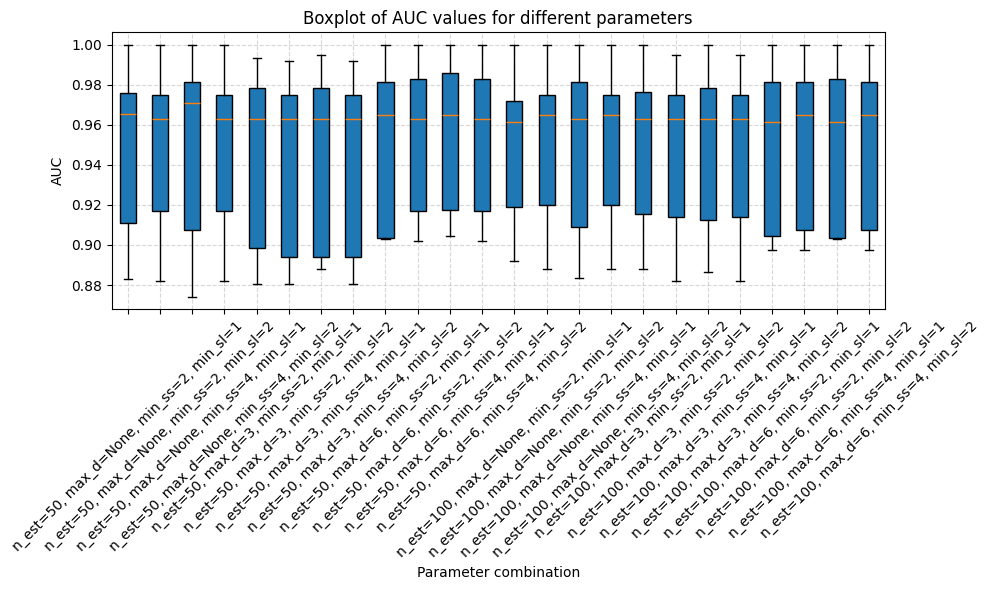

Best parameters found: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}
Best cross-validation score: 0.9546171364867015


In [45]:
# 随机森林
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100],      # 决策树的数量
    'max_depth': [None, 3, 6],       # 树的最大深度
    'min_samples_split': [2, 4],     # 内部节点再划分所需的最小样本数
    'min_samples_leaf': [1, 2]       # 叶子节点所需的最小样本数
}

# 初始化随机森林分类器
rf_classifier = RandomForestClassifier(random_state=42)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_PCA, y_PCA)

# 提取每组参数对应的AUC值
auc_values = []
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['n_estimators'] == n_estimators and grid_search.cv_results_['params'][j]['max_depth'] == max_depth and grid_search.cv_results_['params'][j]['min_samples_split'] == min_samples_split and grid_search.cv_results_['params'][j]['min_samples_leaf'] == min_samples_leaf])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
plt.xticks(ticks=np.arange(1, len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) + 1), labels=[f"n_est={n_estimators}, max_d={max_depth}, min_ss={min_samples_split}, min_sl={min_samples_leaf}" for n_estimators in param_grid['n_estimators'] for max_depth in param_grid['max_depth'] for min_samples_split in param_grid['min_samples_split'] for min_samples_leaf in param_grid['min_samples_leaf']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_rf_classifier_PCA = grid_search.best_estimator_

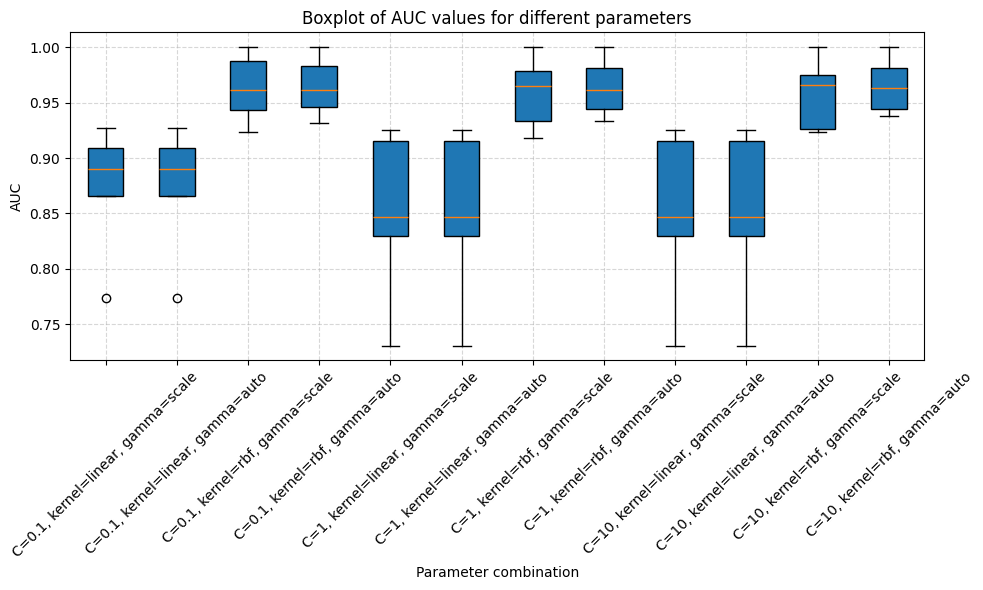

Best parameters found: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.9654022137283007


In [46]:
# SVM
# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],              # 正则化参数
    'kernel': ['linear', 'rbf'],    # 核函数类型
    'gamma': ['scale', 'auto']      # 核系数
}

# 初始化 SVM 分类器
svm_classifier = SVC(random_state=42,probability=True)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_PCA, y_PCA)

# 提取每组参数对应的 AUC 值
auc_values = []
for C in param_grid['C']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['C'] == C and grid_search.cv_results_['params'][j]['kernel'] == kernel and grid_search.cv_results_['params'][j]['gamma'] == gamma])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e']
plt.xticks(ticks=np.arange(1, len(param_grid['C']) * len(param_grid['kernel']) * len(param_grid['gamma']) + 1), labels=[f"C={C}, kernel={kernel}, gamma={gamma}" for C in param_grid['C'] for kernel in param_grid['kernel'] for gamma in param_grid['gamma']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_svm_classifier_PCA = grid_search.best_estimator_

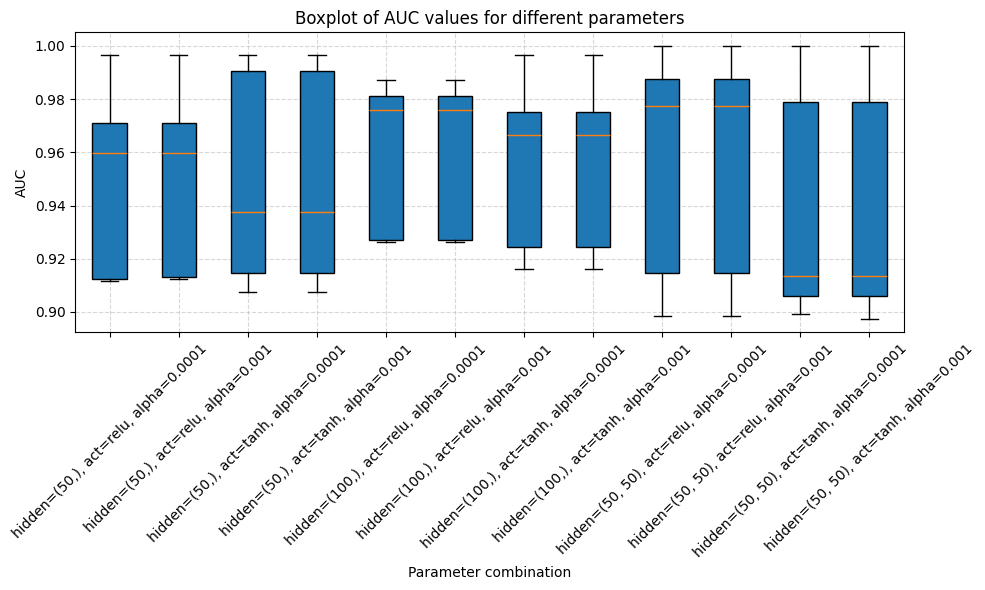

Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Best cross-validation score: 0.9595194503953269


In [47]:
# 神经网络
# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],   # 隐藏层神经元数量
    'activation': ['relu', 'tanh'],                    # 激活函数类型
    'solver': ['adam'],                                # 优化器类型
    'alpha': [0.0001, 0.001]                           # L2正则化参数
}

# 初始化神经网络分类器
nn_classifier = MLPClassifier(random_state=42, max_iter=1000)

# 定义五折交叉验证
fold = 5
kf = KFold(n_splits=fold, shuffle=True, random_state=42)

# 初始化 GridSearchCV
grid_search = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, 
                           cv=kf, scoring='roc_auc', n_jobs=-1)

# 进行网格搜索
grid_search.fit(X_PCA, y_PCA)

# 提取每组参数对应的 AUC 值
auc_values = []
for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for alpha in param_grid['alpha']:
            auc_values.append([grid_search.cv_results_[f'split{i}_test_score'][j] for i in range(fold) for j in range(len(grid_search.cv_results_['params'])) if grid_search.cv_results_['params'][j]['hidden_layer_sizes'] == hidden_layer_sizes and grid_search.cv_results_['params'][j]['activation'] == activation and grid_search.cv_results_['params'][j]['alpha'] == alpha])

# 绘制箱线图
plt.figure(figsize=(10, 6))
bp = plt.boxplot(auc_values, patch_artist=True)
colors = ['#1f77b4', '#ff7f0e']
plt.xticks(ticks=np.arange(1, len(param_grid['hidden_layer_sizes']) * len(param_grid['activation']) * len(param_grid['alpha']) + 1), labels=[f"hidden={hidden_layer_sizes}, act={activation}, alpha={alpha}" for hidden_layer_sizes in param_grid['hidden_layer_sizes'] for activation in param_grid['activation'] for alpha in param_grid['alpha']], rotation=45)
plt.title('Boxplot of AUC values for different parameters')
plt.xlabel('Parameter combination')
plt.ylabel('AUC')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 输出最佳参数
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 使用最佳参数训练模型
best_nn_classifier_PCA = grid_search.best_estimator_

## 分析训练模型在自己划分的测试集上的性能

In [48]:
print(f'测试集大小：{test.shape}')
test_X = pca_optimal.fit_transform(test.drop(columns=['target']))
test_y = test['target']

测试集大小：(75, 301)


In [49]:
# 预测
# logistic_PCA = best_logreg_classifier_PCA.predict(test_X)
# rf_PCA= best_rf_classifier_PCA.predict(test_X)
# svm_PCA = best_svm_classifier_PCA.predict(test_X)
# nn_PCA = best_nn_classifier_PCA.predict(test_X)

# result_PCA = pd.DataFrame(test['target'])
# result_PCA['logsitic_pred'] = logistic_PCA
# result_PCA['rf_pred'] = rf_PCA
# result_PCA['svm_pred'] = svm_PCA
# result_PCA['nn_pred'] = nn_PCA
# print(f'accuracy_logistic:{np.sum(logistic_PCA==test_y)/test.shape[0]}\n')
# print(f'accuracy_rf:{np.sum(rf_PCA==test_y)/test.shape[0]}\n')
# print(f'accuracy_svm:{np.sum(svm_PCA==test_y)/test.shape[0]}\n')
# print(f'accuracy_nn:{np.sum(nn_PCA==test_y)/test.shape[0]}\n')

主成分分析（PCA）的预测性能不佳，在0.6左右，不选用该方法做降维。